In [1]:
# Import relevant libraries 

import re
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import top_k_accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, mean_absolute_error
#from scikitplot.metrics import plot_roc

In [2]:
warnings.filterwarnings("ignore")

# https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

#plt.style.use('seaborn-v0_8-colorblind')
#plt.style.use('default')
#plt.style.use('seaborn-v0_8-dark-palette')
plt.style.use('seaborn-pastel')


In [3]:
#Define configs

class CFG:
    SEED = 768
    BATCH_SIZE = 32
    EPOCHS = 10

In [4]:
def seed_everything(seed=CFG.SEED):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(CFG.SEED)

In [5]:
# Define paths
DATASET_PATH = "/kaggle/input/nlp-sentiments-analysis"
TRAIN_CSV = '/kaggle/input/nlp-sentiments-analysis/train.csv'
TEST_CSV = '/kaggle/input/nlp-sentiments-analysis/test.csv'
SAMPLE_SUB_CSV = '/kaggle/input/nlp-sentiments-analysis/sample_submission.csv'

# Dataset Exploration

In [6]:
# Load the csv files
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
submission_df = pd.read_csv(SAMPLE_SUB_CSV) 

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      60000 non-null  int64 
 1   Review  60000 non-null  object
 2   Rating  60000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


In [8]:
train_df.head(5)

,Id,Review,Rating
0,0,Very good value and a great tv very happy and ...,5
1,1,After 6 month still can't access my account,3
2,2,I couldn't make an official review on a produc...,1
3,3,"Fantastic! Extremely easy to use website, fant...",5
4,4,So far annoyed as hell with this bt monthly pa...,1


In [9]:
# view random selected data

def view_samples(df, count=5):
    idx = random.sample(train_df.index.to_list(), count)
    print('=========================================\n')
    for _ in idx:
        print(f'id:\t{df.Id[_]}\n')
        print(f'Review:\n{df.Review[_]}\n')
        print(f'Rating:\n{df.Rating[_]}')
        print('=========================================\n')

In [10]:
# view randomly selected data

view_samples(train_df, count=5)


id:	5732

Review:
Easy to use, quick delivery and excellent quality prints.

Rating:
5

id:	17207

Review:
Great site, sold dozens of accounts on it, and always get my money for sales.

Rating:
5

id:	29922

Review:
Clear info on website, good delivery and product was exactly what I was looking for.

Rating:
5

id:	19055

Review:
I have tried to get a contract with them, and for some reason I am not eligible

I asked them to give me more details and they replied

-you’re are not registered on the Electoral list

This is a bit weird to be honest....

Rating:
1

id:	58751

Review:
I ordered a laptop on the 3rd May configured to my requirements. On the 4th I received an email telling me there was no stock of the chassis I'd chosen despite it still being shown as available on their website.
On the 5th of May I chose another chassis at the additional cost of £20. The order went through and was delivered by DPD on the 10th May.
I connected the laptop to the mains and at first it refused to 

In [11]:
train_distribution = train_df['Rating'].value_counts().sort_values()
train_distribution

Rating
2     1629
3     1679
4     3350
1    18663
5    34679
Name: count, dtype: int64

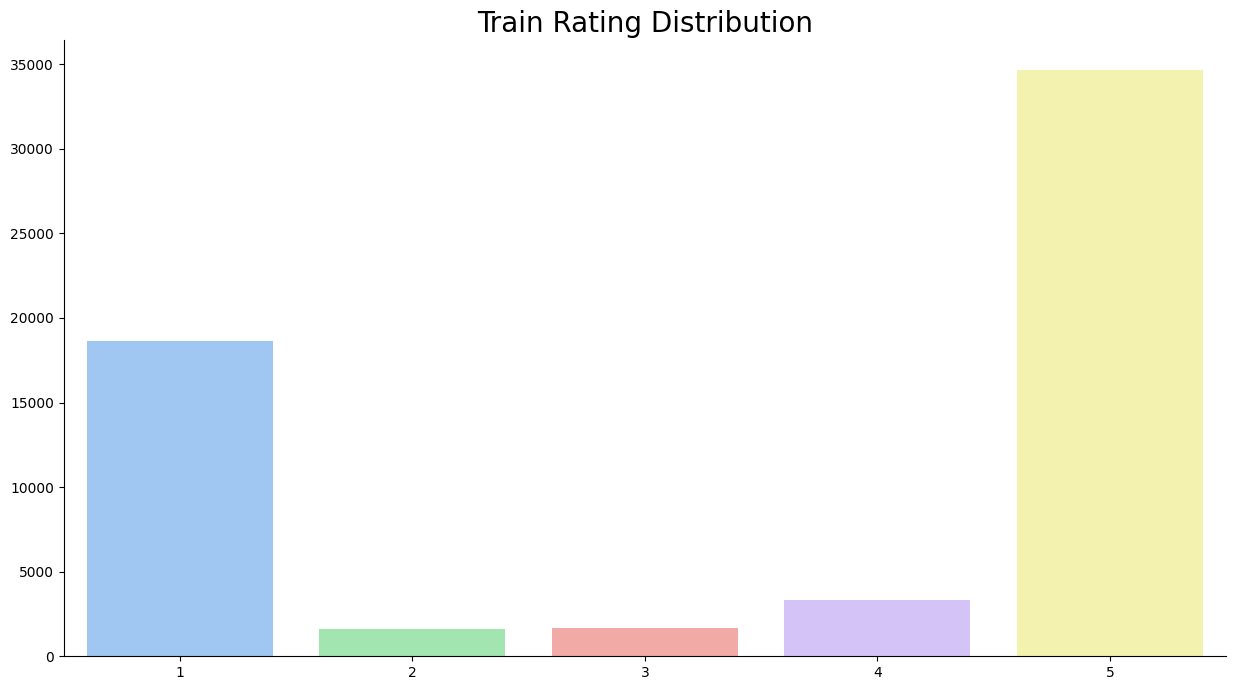

In [12]:
# View Train Rating Distribution
plt.figure(figsize=(15, 8))
plt.title('Train Rating Distribution', fontsize=20)

train_distribution = train_df['Rating'].value_counts().sort_values()
sns.barplot(x=list(train_distribution.keys()),
            y=train_distribution.values);

sns.despine();

In [13]:
# Get the lengths of each review
train_df['review_length'] = [len(_) for _ in train_df.Review]

# Get the number of tokens per review 
train_df['token_count'] = [len(_.split()) for _ in train_df.Review]

In [14]:
train_df.head(5)

,Id,Review,Rating,review_length,token_count
0,0,Very good value and a great tv very happy and ...,5,89,18
1,1,After 6 month still can't access my account,3,43,8
2,2,I couldn't make an official review on a produc...,1,496,92
3,3,"Fantastic! Extremely easy to use website, fant...",5,197,32
4,4,So far annoyed as hell with this bt monthly pa...,1,222,49


In [15]:
print(f"{train_df['review_length'].describe()}")

count    60000.000000
mean       309.070083
std        423.772492
min         31.000000
25%         82.000000
50%        164.000000
75%        358.000000
max       7794.000000
Name: review_length, dtype: float64


In [16]:
print(f"{train_df['token_count'].describe()}")

count    60000.00000
mean        56.56325
std         79.35289
min          1.00000
25%         14.00000
50%         29.00000
75%         66.00000
max       1439.00000
Name: token_count, dtype: float64


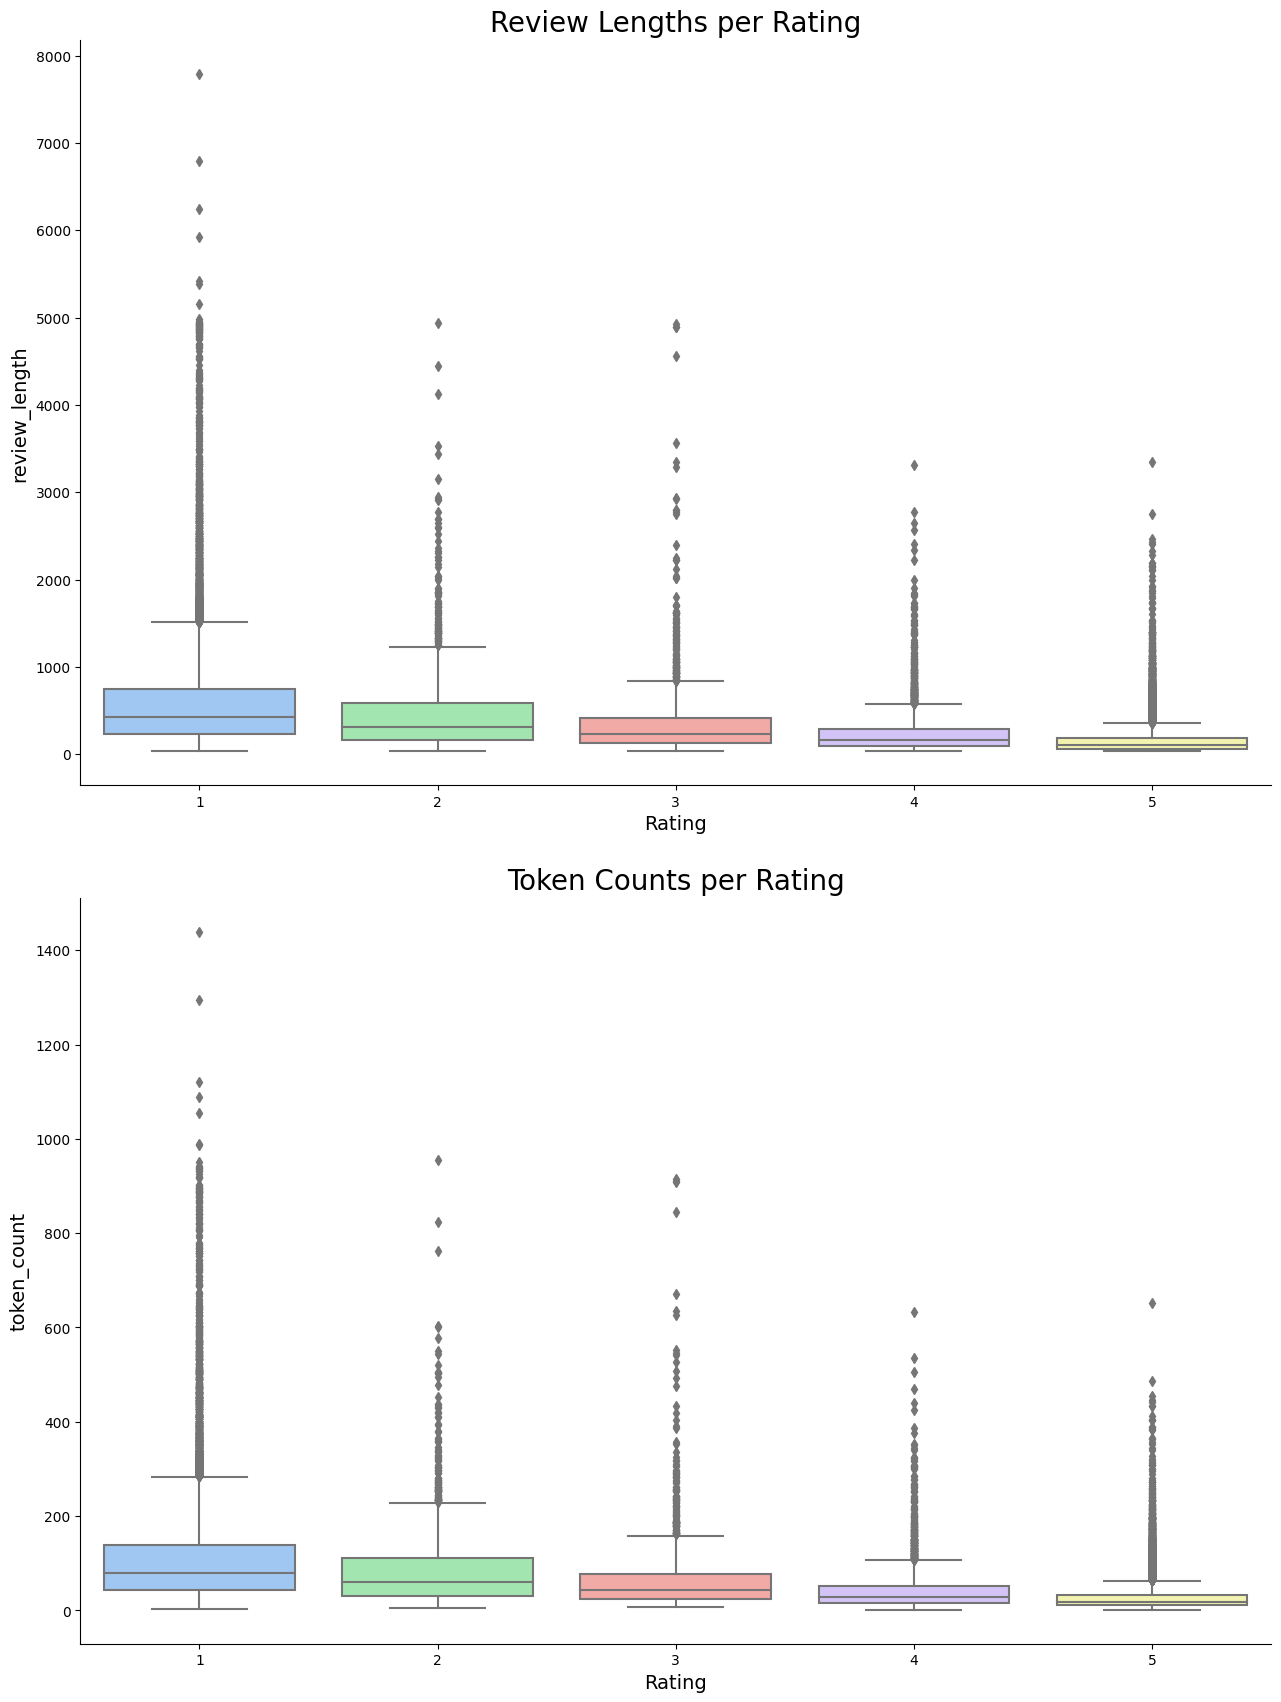

In [19]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 18))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Range of Review Lengths per Rating
ax1.set_title('Review Lengths per Rating', fontsize=20)
sns.boxplot(data=train_df, y='review_length', x='Rating',
            ax=ax1)
ax1.set_xlabel('Rating', fontsize=14)
ax1.set_ylabel('review_length', fontsize=14)
sns.despine();

# Plot Range of Token Counts per Rating
ax2.set_title('Token Counts per Rating', fontsize=20)
sns.boxplot(data=train_df, y='token_count', x='Rating',
            ax=ax2);
ax2.set_xlabel('Rating', fontsize=14)
ax2.set_ylabel('token_count', fontsize=14)
sns.despine();

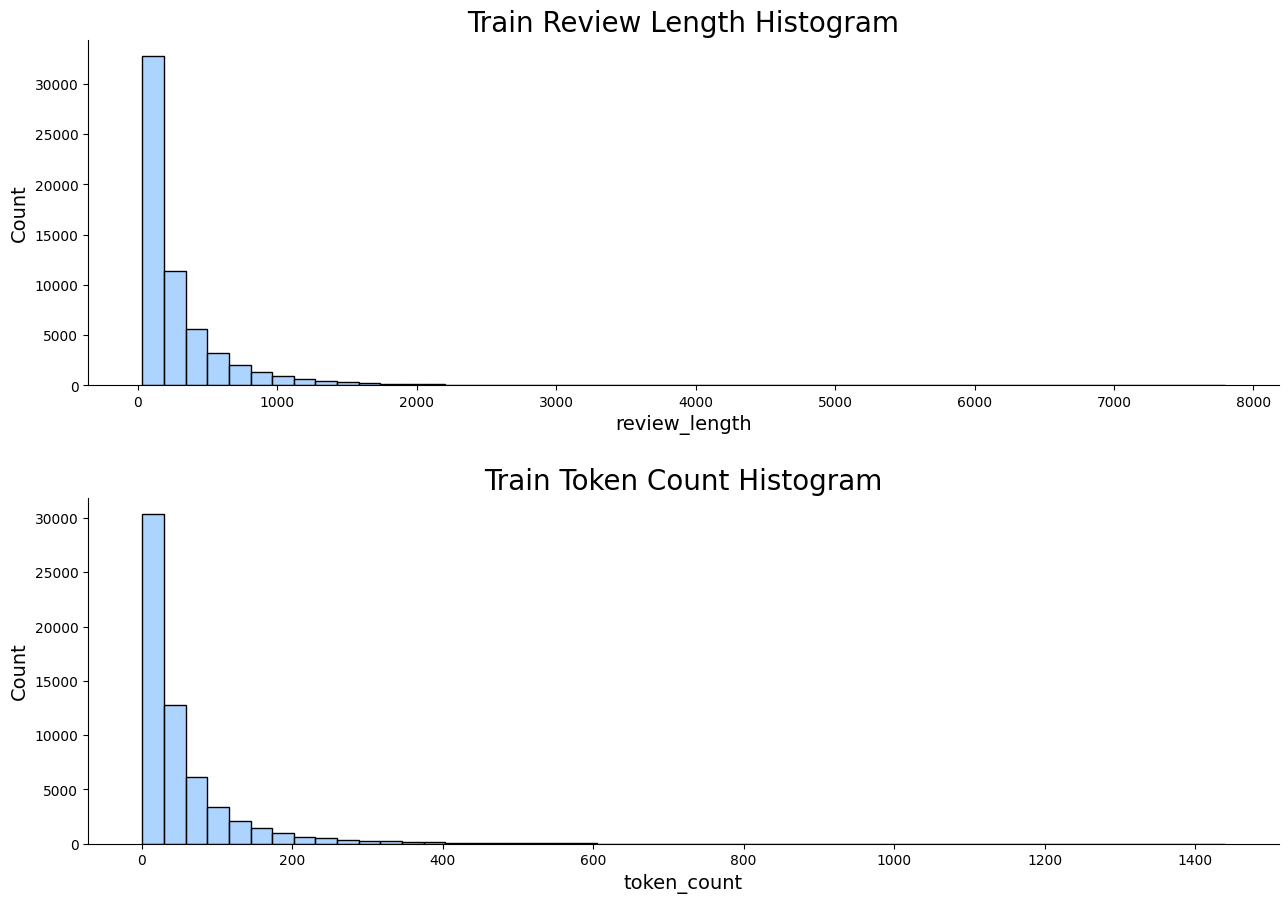

In [20]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Generate Train Rating Histogram
ax1.set_title('Train Review Length Histogram', fontsize=20)
sns.histplot(data=train_df, x='review_length', bins=50,
            ax=ax1)
ax1.set_xlabel('review_length', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)
sns.despine();

# Generate Train Token Count Histogram
ax2.set_title('Train Token Count Histogram', fontsize=20)
sns.histplot(data=train_df, x='token_count', bins=50,
            ax=ax2)
ax2.set_xlabel('token_count', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)
sns.despine();

# Data Preprocessing

In [21]:
# Label encode ratings
train_df["rating_encoded"] = train_df['Rating'] - 1

In [23]:
train_df.head(5)

,Id,Review,Rating,review_length,token_count,rating_encoded
0,0,Very good value and a great tv very happy and ...,5,89,18,4
1,1,After 6 month still can't access my account,3,43,8,2
2,2,I couldn't make an official review on a produc...,1,496,92,0
3,3,"Fantastic! Extremely easy to use website, fant...",5,197,32,4
4,4,So far annoyed as hell with this bt monthly pa...,1,222,49,0


In [24]:
# get indices of training and test data sets. 
train_idx, val_idx, _, _ = train_test_split(
    train_df.index, train_df.Rating, 
    test_size=0.2, stratify=train_df.Rating,
    random_state=CFG.SEED
)

In [26]:
val_idx

Index([ 9498, 50185, 43180,  6799, 35461, 37992, 44980, 33859,  7593, 30752,
       ...
       11595, 24905, 29628, 30865,   736,  8536, 31698, 25568, 44752, 16440],
      dtype='int64', length=12000)

In [27]:
train_new_df = train_df.iloc[train_idx].reset_index(drop= True)
val_df = train_df.iloc[val_idx].reset_index(drop = True)

In [28]:
train_new_df

,Id,Review,Rating,review_length,token_count,rating_encoded
0,7372,Straight forward purchase from trusted supplie...,5,80,12,4
1,36260,Website is super smooth and easy to navigate w...,5,118,21,4
2,33497,"Apparently it was posted twice, maybe it will ...",1,150,26,0
3,36775,Order received the day after order. Memory upg...,5,94,15,4
4,49630,"Its great, in a contract with them for 30GB fo...",5,162,27,4
...,...,...,...,...,...,...
47995,40748,I have made 2 purchases with PCSPECIALIST in t...,5,91,17,4
47996,33270,Matress is amazing- thank you\nYet again deliv...,2,402,78,1
47997,16802,Gtech have a great product I always buy from t...,5,134,25,4
47998,37531,"Quick delivery, competitive price",5,33,4,4


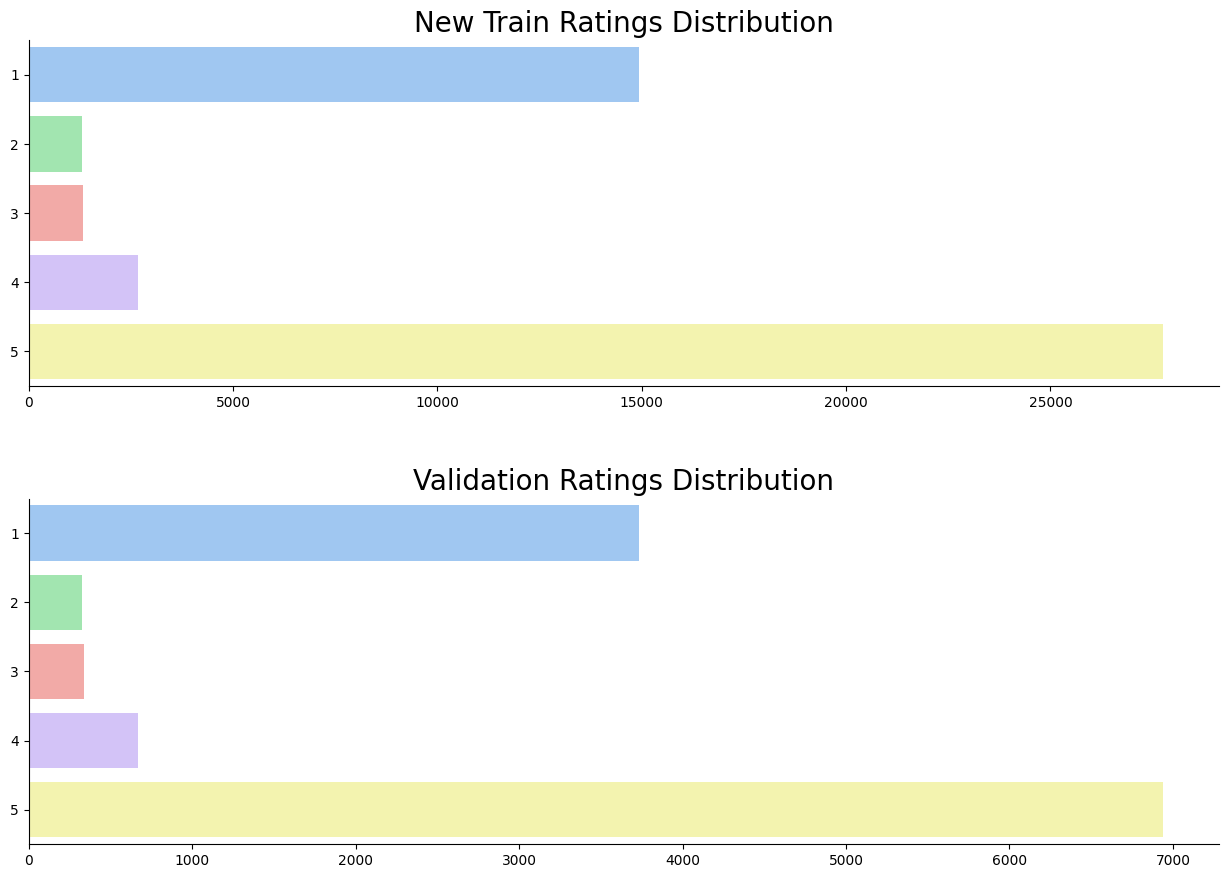

In [29]:
# Train and Test Rating Distribution 
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot New Train Ratings Distribution
ax1.set_title('New Train Ratings Distribution', fontsize=20)
train_new_distribution = train_new_df['Rating'].value_counts().sort_values()
sns.barplot(x=train_new_distribution.values,
            y=list(train_new_distribution.keys()),
            orient="h",
            ax=ax1)
sns.despine();

# Plot Validation Ratings Distribution
ax2.set_title('Validation Ratings Distribution', fontsize=20)
val_distribution = val_df['Rating'].value_counts().sort_values()
sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h",
            ax=ax2);
sns.despine();

------------------------------------------------------------------------

# Build Input Data Pipeline with tf.data API

we'll use the tf.data API to build input data pipelines for training a model and conducting model inference. In order to achieve this, we'll preprocess the reviews by removing any artifacts in the texts such as emojis, non-ascii characters and replacing numbers with another character. The preprocessed texts will be used to construct the pipelines along with the one-hot encoded ratings.

For more information on the tf.data API and loading data from generator, follow these links:


* tf.data: Build TensorFlow input pipelines - https://www.tensorflow.org/guide/data
* Better performance with the tf.data API - https://www.tensorflow.org/guide/data_performance
* Using generators with tf.data API -https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator

### Define Text Preprocessor

In [31]:
def text_preprocessor(text):
    
    # -----------------------------------------------------
    # Source: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    # -----------------------------------------------------
    non_ascii_pattern = re.compile(r"[^\x00-\x7F]+", flags=re.UNICODE)
    digit_pattern = re.compile('[0-9]', flags=re.UNICODE)
    
    # -----------------------------------------------------
    # Source: https://stackoverflow.com/questions/21932615/regular-expression-for-remove-link
    link_pattern = re.compile('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', flags=re.UNICODE)
    # -----------------------------------------------------
    
    # Remove emojis
    preprocessed_text = emoji_pattern.sub(r'', text)
    # Remove non-ascii characters
    preprocessed_text = non_ascii_pattern.sub(r'', preprocessed_text)
    # Replace numbers with '#' sign
    preprocessed_text = digit_pattern.sub(r'#', preprocessed_text)
    # Remove web links 
    preprocessed_text = link_pattern.sub(r'', preprocessed_text)
    
    return preprocessed_text